In [30]:
!apt-get update -y
!apt-get install -y openjdk-11-jdk-headless

SPARK_VERSION = "3.4.1"
HADOOP_VERSION = "3"

spark_url = f"https://archive.apache.org/dist/spark/spark-{SPARK_VERSION}/spark-{SPARK_VERSION}-bin-hadoop{HADOOP_VERSION}.tgz"

print("⬇️ Downloading:", spark_url)
!wget -q -O /content/spark.tgz "$spark_url"

!tar -xzf /content/spark.tgz
!pip install -q pyspark findspark gcsfs google-cloud-storage

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/spark-{SPARK_VERSION}-bin-hadoop{HADOOP_VERSION}"
os.environ["PATH"] += ":" + os.path.join(os.environ["SPARK_HOME"], "bin")

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ColabSparkFixed").getOrCreate()

print("✅ Spark started successfully!")
print("Spark version:", spark.version)
spark.range(5).show()


Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [31]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/spark-{SPARK_VERSION}-bin-hadoop{HADOOP_VERSION}"
os.environ["PATH"] += ":" + os.path.join(os.environ["SPARK_HOME"], "bin")

import findspark
findspark.init(os.environ["SPARK_HOME"])

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("HospitalReadmission").getOrCreate()
spark.sparkContext.setLogLevel("WARN")
print("Spark version:", spark.version)


Spark version: 3.4.1


In [32]:
# Try to mount Google Drive. If you don't want to use Drive, upload the CSV via Colab UI (Files -> Upload).
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    print("Drive mounted.")
except Exception as e:
    print("Drive mount not available or skipped.", str(e))

# Provide the possible file paths. Change as necessary.
drive_path = "/content/hospital_readmissions_30k.csv"
local_path = "/content/hospital_readmissions_30k.csv"

# Choose the existing one
import os
if os.path.exists(drive_path):
    data_path = drive_path
elif os.path.exists(local_path):
    data_path = local_path
else:
    raise FileNotFoundError(f"CSV not found. Put file at {drive_path} or upload to {local_path}")

print("Using data file:", data_path)


Mounted at /content/drive
Drive mounted.
Using data file: /content/hospital_readmissions_30k.csv


In [33]:
# Read with spark (handles big datasets)
df_spark = spark.read.option("header", True).option("inferSchema", True).csv(data_path)
print(f"Rows: {df_spark.count():,}, Columns: {len(df_spark.columns)}")
df_spark.printSchema()

# Convert to pandas for EDA & modelling (30k rows ok)
df = df_spark.toPandas()
df.shape


Rows: 30,000, Columns: 12
root
 |-- patient_id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- blood_pressure: string (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- diabetes: string (nullable = true)
 |-- hypertension: string (nullable = true)
 |-- medication_count: integer (nullable = true)
 |-- length_of_stay: integer (nullable = true)
 |-- discharge_destination: string (nullable = true)
 |-- readmitted_30_days: string (nullable = true)



(30000, 12)

In [34]:
import pandas as pd, numpy as np
pd.set_option('display.max_columns', 120)
df.head(5)

,patient_id,age,gender,blood_pressure,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,readmitted_30_days
0,1,74,Other,130/72,240,31.5,Yes,No,5,1,Nursing_Facility,Yes
1,2,46,Female,120/92,292,36.3,No,No,4,3,Nursing_Facility,No
2,3,89,Other,135/78,153,30.3,No,Yes,1,1,Home,No
3,4,84,Female,123/80,153,31.5,No,Yes,3,10,Home,No
4,5,32,Other,135/84,205,18.4,No,Yes,6,4,Nursing_Facility,No


Please make sure to execute the cell that converts the Spark DataFrame to a Pandas DataFrame (cell `2i7QF2Y8GFuG`) before running the subsequent cells.

In [35]:
import pandas as pd, numpy as np
pd.set_option('display.max_columns', 120)
display(df.head(5))

,patient_id,age,gender,blood_pressure,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,readmitted_30_days
0,1,74,Other,130/72,240,31.5,Yes,No,5,1,Nursing_Facility,Yes
1,2,46,Female,120/92,292,36.3,No,No,4,3,Nursing_Facility,No
2,3,89,Other,135/78,153,30.3,No,Yes,1,1,Home,No
3,4,84,Female,123/80,153,31.5,No,Yes,3,10,Home,No
4,5,32,Other,135/84,205,18.4,No,Yes,6,4,Nursing_Facility,No


In [36]:
# Normalize/clean column names to snake_case
def clean_col(c):
    return (c.strip()
             .lower()
             .replace(" ", "_")
             .replace("(", "")
             .replace(")", "")
             .replace("#", "")
             .replace("-", "_"))

df.columns = [clean_col(c) for c in df.columns]
df.rename(columns={
    'age': 'age',
    'time_in_hospital': 'time_in_hospital',
    'n_lab_procedures': 'n_lab_procedures',
    'n_procedures': 'n_procedures',
    'n_medications': 'n_medications',
    'n_outpatient': 'n_outpatient',
    'n_inpatient': 'n_inpatient',
    'n_emergency': 'n_emergency',
    'medical_specialty': 'medical_specialty',
    'diag_1': 'diag_1',
    'diag_2': 'diag_2',
    'diag_3': 'diag_3',
    'glucose_test': 'glucose_test',
    'a1ctest': 'a1ctest',
    'change': 'change',
    'diabetes_med': 'diabetes_med',
    'readmitted': 'readmitted'
}, inplace=True)
display(df.head(3))

,patient_id,age,gender,blood_pressure,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,readmitted_30_days
0,1,74,Other,130/72,240,31.5,Yes,No,5,1,Nursing_Facility,Yes
1,2,46,Female,120/92,292,36.3,No,No,4,3,Nursing_Facility,No
2,3,89,Other,135/78,153,30.3,No,Yes,1,1,Home,No


In [37]:
# 1) Trim whitespace and lowercase strings
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip()

# 2) Replace common placeholders for missing values
df.replace({"nan": None, "NA": None, "": None, "None": None, "Unknown": None}, inplace=True)

# 3) Convert readmitted to binary target
df['readmitted_binary'] = df['readmitted_30_days'].map(lambda x: 1 if str(x).lower().startswith('y') else 0)

# 4) Basic missing value summary
missing = df.isnull().mean().sort_values(ascending=False)
display(missing.head(20))

# Fill numeric NaNs with median
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
    df[c] = df[c].fillna(df[c].median())

# Fill categorical NaNs with 'Unknown'
cat_cols = [c for c in df.select_dtypes(include='object').columns if c not in ['readmitted_30_days']]
for c in cat_cols:
    df[c] = df[c].fillna('Unknown')

,0
patient_id,0.0
age,0.0
gender,0.0
blood_pressure,0.0
cholesterol,0.0
bmi,0.0
diabetes,0.0
hypertension,0.0
medication_count,0.0
length_of_stay,0.0


In [38]:
# Example: map age bracket to numeric median age
def age_to_med(age_val):
    # If the value is already numeric, return it
    if isinstance(age_val, (int, float)):
        return age_val
    # typical age brackets like "[70-80)" or "70-80" or "80-90"
    import re
    m = re.search(r'(\d+)', str(age_val)) # Convert to string before applying regex
    if not m: return np.nan
    # take first number as representative
    return int(m.group(1))

df['age_num'] = df['age'].apply(age_to_med).fillna(df['age'].median())

# Create total prior visits
df['prior_visits'] = df['medication_count'].astype(int) + df['length_of_stay'].astype(int)

# Flag high glucose / high A1C
# Assuming 'glucose_test' and 'a1ctest' columns exist and contain relevant string data
# based on previous cell's potential data cleaning. If not, this part might need adjustment
if 'glucose_test' in df.columns:
  df['high_glucose'] = df['glucose_test'].astype(str).str.lower().apply(lambda x: 1 if 'high' in x else 0)
else:
  df['high_glucose'] = 0 # Or some other default/handling

if 'a1ctest' in df.columns:
  df['high_a1c'] = df['a1ctest'].astype(str).str.lower().apply(lambda x: 1 if 'high' in x else 0)
else:
  df['high_a1c'] = 0 # Or some other default/handling


# Quick sanity
# Check if the columns exist before trying to display them
cols_to_display = ['age','age_num','medication_count','length_of_stay','prior_visits']
if 'high_glucose' in df.columns:
    cols_to_display.append('high_glucose')
if 'high_a1c' in df.columns:
    cols_to_display.append('high_a1c')
if 'readmitted_binary' in df.columns:
    cols_to_display.append('readmitted_binary')

display(df[cols_to_display].head())

,age,age_num,medication_count,length_of_stay,prior_visits,high_glucose,high_a1c,readmitted_binary
0,74,74,5,1,6,0,0,1
1,46,46,4,3,7,0,0,0
2,89,89,1,1,2,0,0,0
3,84,84,3,10,13,0,0,0
4,32,32,6,4,10,0,0,0


Readmitted distribution (binary):
readmitted_binary
0    0.877533
1    0.122467
Name: proportion, dtype: float64


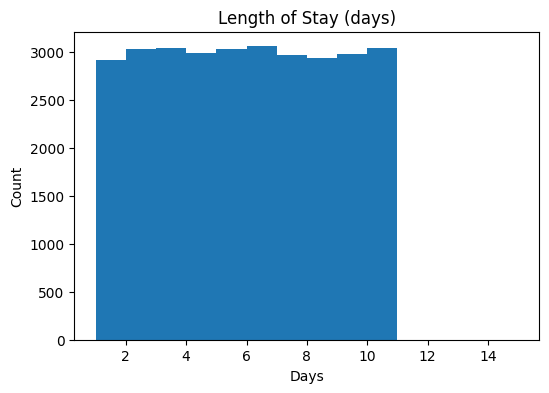

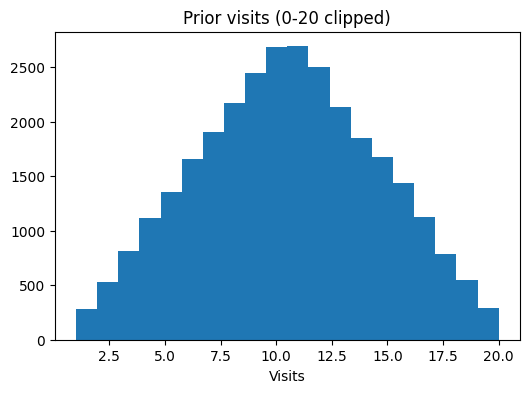

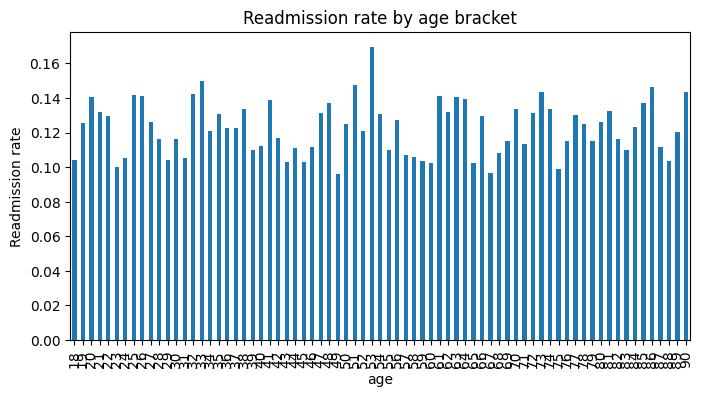

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Target balance
print("Readmitted distribution (binary):")
print(df['readmitted_binary'].value_counts(normalize=True))

# Distribution of time_in_hospital
plt.figure(figsize=(6,4))
plt.hist(df['length_of_stay'].dropna(), bins=range(1,16))
plt.title("Length of Stay (days)")
plt.xlabel("Days")
plt.ylabel("Count")
plt.show()

# Prior visits histogram
plt.figure(figsize=(6,4))
plt.hist(df['prior_visits'].clip(0,20), bins=20)
plt.title("Prior visits (0-20 clipped)")
plt.xlabel("Visits")
plt.show()

# Age categories vs readmission rate
plt.figure(figsize=(8,4))
age_rates = df.groupby('age')['readmitted_binary'].mean().sort_index()
age_rates.plot(kind='bar')
plt.ylabel("Readmission rate")
plt.title("Readmission rate by age bracket")
plt.show()

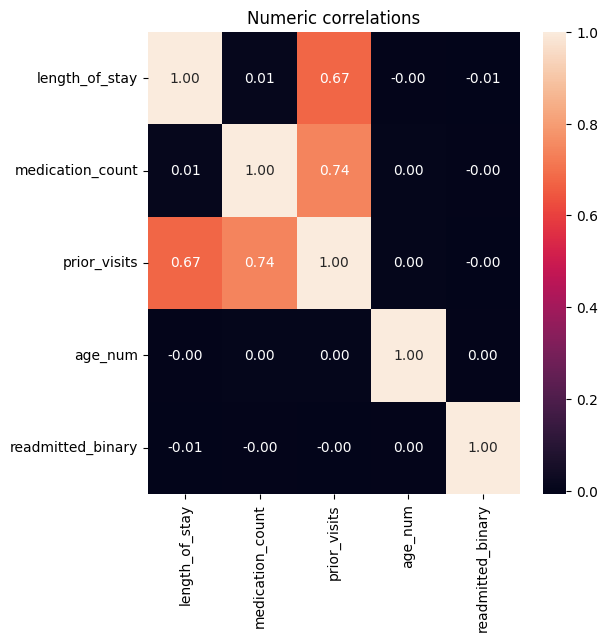

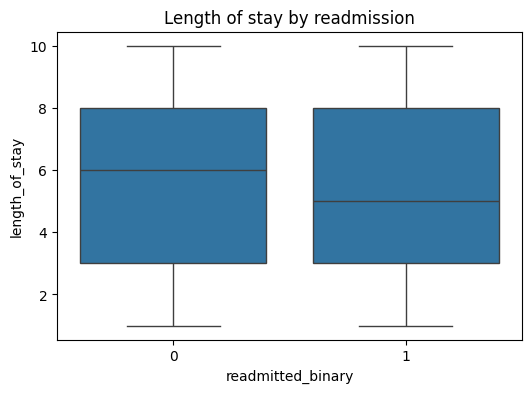

In [43]:
plt.figure(figsize=(6,6))
num_for_corr = ['length_of_stay','medication_count','prior_visits','age_num','readmitted_binary']
sns.heatmap(df[num_for_corr].corr(), annot=True, fmt=".2f")
plt.title("Numeric correlations")
plt.show()

# Boxplot: time_in_hospital by readmission
plt.figure(figsize=(6,4))
sns.boxplot(x='readmitted_binary', y='length_of_stay', data=df)
plt.title("Length of stay by readmission")
plt.show()

In [44]:
# Filter examples - adjust values to explore
filtered = df[
    (df['age'] >= 70) &          # age is 70 or greater (change as needed)
    (df['length_of_stay'] >= 3)
]
print("Filtered rows:", filtered.shape[0])
display(filtered.head(5))

Filtered rows: 6828


,patient_id,age,gender,blood_pressure,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,readmitted_30_days,readmitted_binary,age_num,prior_visits,high_glucose,high_a1c
3,4,84,Female,123/80,153,31.5,No,Yes,3,10,Home,No,0,84,13,0,0
5,6,75,Female,139/100,194,33.5,No,Yes,0,10,Home,No,0,75,10,0,0
14,15,87,Other,110/93,277,38.7,Yes,No,6,3,Home,Yes,1,87,9,0,0
15,16,90,Other,127/93,230,20.0,No,Yes,0,3,Home,No,0,90,3,0,0
17,18,80,Female,116/89,217,37.0,No,Yes,8,3,Home,No,0,80,11,0,0


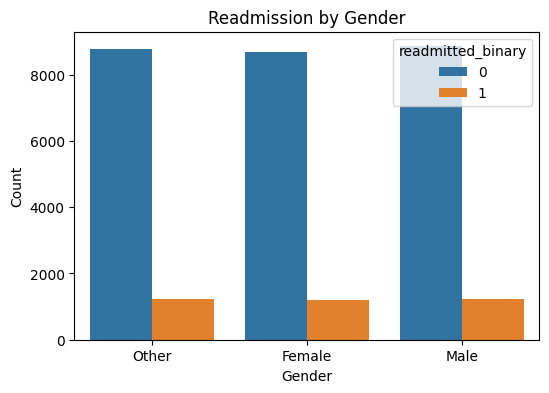

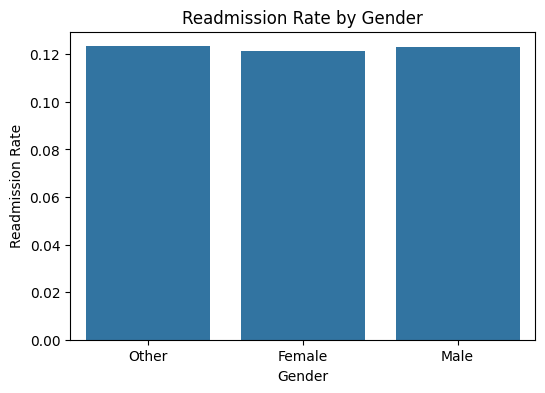

In [45]:
# Explore Gender distribution and readmission rate
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', hue='readmitted_binary', data=df)
plt.title('Readmission by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(x='gender', y='readmitted_binary', data=df, errorbar=None)
plt.title('Readmission Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Readmission Rate')
plt.show()

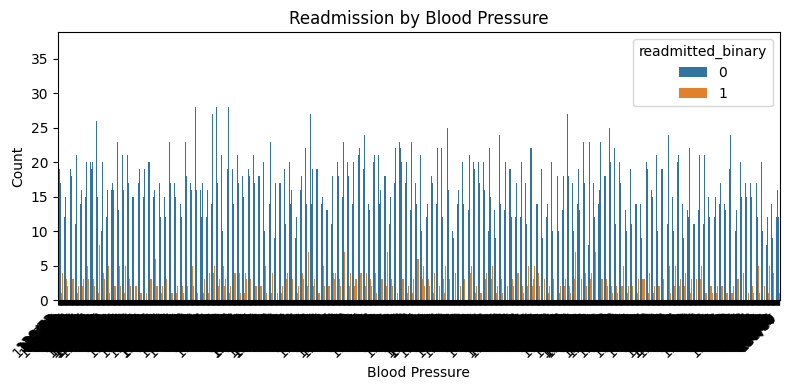

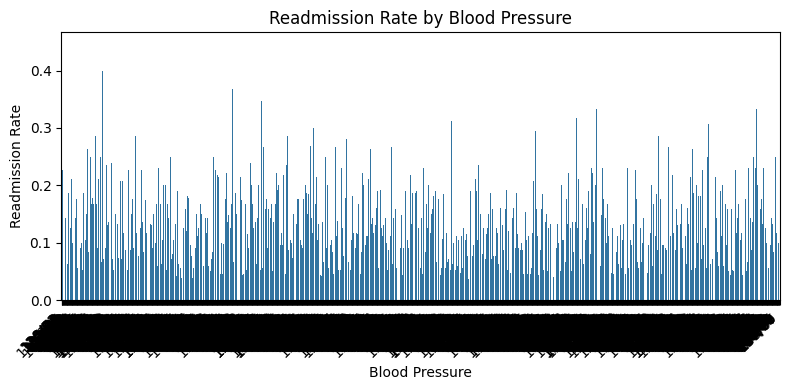

In [46]:
# Explore Blood Pressure distribution and readmission rate
plt.figure(figsize=(8, 4))
sns.countplot(x='blood_pressure', hue='readmitted_binary', data=df)
plt.title('Readmission by Blood Pressure')
plt.xlabel('Blood Pressure')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x='blood_pressure', y='readmitted_binary', data=df, errorbar=None)
plt.title('Readmission Rate by Blood Pressure')
plt.xlabel('Blood Pressure')
plt.ylabel('Readmission Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

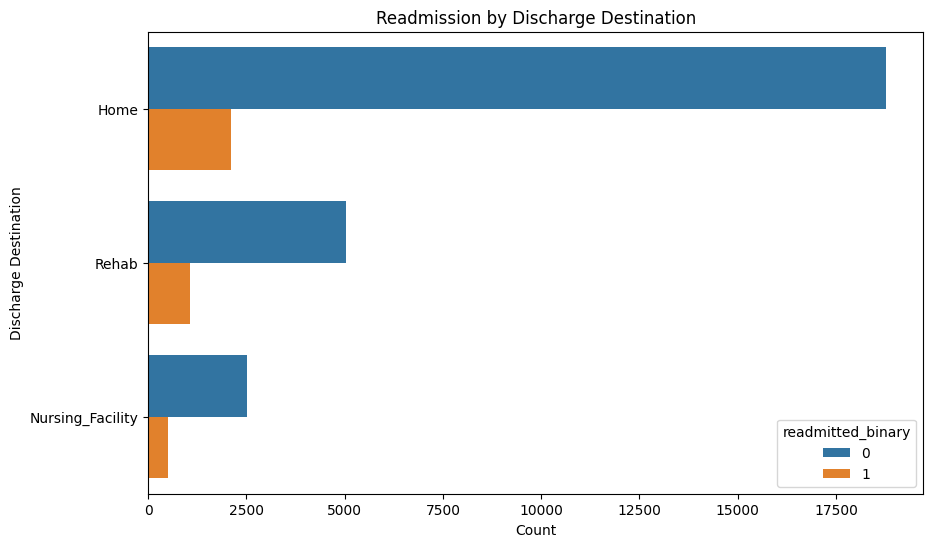

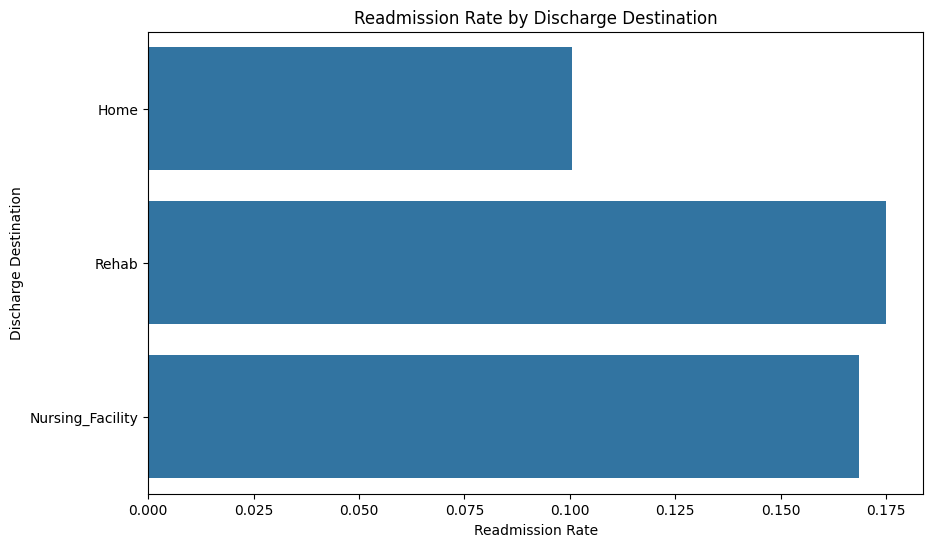

In [47]:
# Explore Discharge Destination distribution and readmission rate
plt.figure(figsize=(10, 6))
sns.countplot(y='discharge_destination', hue='readmitted_binary', data=df, order=df['discharge_destination'].value_counts().index)
plt.title('Readmission by Discharge Destination')
plt.xlabel('Count')
plt.ylabel('Discharge Destination')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(y='discharge_destination', x='readmitted_binary', data=df, errorbar=None, order=df['discharge_destination'].value_counts().index)
plt.title('Readmission Rate by Discharge Destination')
plt.xlabel('Readmission Rate')
plt.ylabel('Discharge Destination')
plt.show()

In [48]:
# Normalize/clean column names to snake_case
def clean_col(c):
    return (c.strip()
             .lower()
             .replace(" ", "_")
             .replace("(", "")
             .replace(")", "")
             .replace("#", "")
             .replace("-", "_"))

df.columns = [clean_col(c) for c in df.columns]
df.rename(columns={
    'age': 'age',
    'time_in_hospital': 'time_in_hospital',
    'n_lab_procedures': 'n_lab_procedures',
    'n_procedures': 'n_procedures',
    'n_medications': 'n_medications',
    'n_outpatient': 'n_outpatient',
    'n_inpatient': 'n_inpatient',
    'n_emergency': 'n_emergency',
    'medical_specialty': 'medical_specialty',
    'diag_1': 'diag_1',
    'diag_2': 'diag_2',
    'diag_3': 'diag_3',
    'glucose_test': 'glucose_test',
    'a1ctest': 'a1ctest',
    'change': 'change',
    'diabetes_med': 'diabetes_med',
    'readmitted': 'readmitted'
}, inplace=True)
df.head(3)


,patient_id,age,gender,blood_pressure,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,readmitted_30_days,readmitted_binary,age_num,prior_visits,high_glucose,high_a1c
0,1,74,Other,130/72,240,31.5,Yes,No,5,1,Nursing_Facility,Yes,1,74,6,0,0
1,2,46,Female,120/92,292,36.3,No,No,4,3,Nursing_Facility,No,0,46,7,0,0
2,3,89,Other,135/78,153,30.3,No,Yes,1,1,Home,No,0,89,2,0,0


In [49]:
# 1) Trim whitespace and lowercase strings
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip()

# 2) Replace common placeholders for missing values
df.replace({"nan": None, "NA": None, "": None, "None": None, "Unknown": None}, inplace=True)

# 3) Convert readmitted to binary target
df['readmitted_binary'] = df['readmitted_30_days'].map(lambda x: 1 if str(x).lower().startswith('y') else 0)

# 4) Basic missing value summary
missing = df.isnull().mean().sort_values(ascending=False)
missing.head(20)

# Fill numeric NaNs with median
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
    df[c] = df[c].fillna(df[c].median())

# Fill categorical NaNs with 'Unknown'
cat_cols = [c for c in df.select_dtypes(include='object').columns if c not in ['readmitted_30_days']]
for c in cat_cols:
    df[c] = df[c].fillna('Unknown')

In [50]:
# Example: map age bracket to numeric median age
def age_to_med(age_val):
    # If the value is already numeric, return it
    if isinstance(age_val, (int, float)):
        return age_val
    # typical age brackets like "[70-80)" or "70-80" or "80-90"
    import re
    m = re.search(r'(\d+)', str(age_val)) # Convert to string before applying regex
    if not m: return np.nan
    # take first number as representative
    return int(m.group(1))

df['age_num'] = df['age'].apply(age_to_med).fillna(df['age'].median())

# Create total prior visits
df['prior_visits'] = df['medication_count'].astype(int) + df['length_of_stay'].astype(int)

# Flag high glucose / high A1C
# Assuming 'glucose_test' and 'a1ctest' columns exist and contain relevant string data
# based on previous cell's potential data cleaning. If not, this part might need adjustment
if 'glucose_test' in df.columns:
  df['high_glucose'] = df['glucose_test'].astype(str).str.lower().apply(lambda x: 1 if 'high' in x else 0)
else:
  df['high_glucose'] = 0 # Or some other default/handling

if 'a1ctest' in df.columns:
  df['high_a1c'] = df['a1ctest'].astype(str).str.lower().apply(lambda x: 1 if 'high' in x else 0)
else:
  df['high_a1c'] = 0 # Or some other default/handling


# Quick sanity
# Check if the columns exist before trying to display them
cols_to_display = ['age','age_num','medication_count','length_of_stay','prior_visits']
if 'high_glucose' in df.columns:
    cols_to_display.append('high_glucose')
if 'high_a1c' in df.columns:
    cols_to_display.append('high_a1c')
if 'readmitted_binary' in df.columns:
    cols_to_display.append('readmitted_binary')

display(df[cols_to_display].head())

,age,age_num,medication_count,length_of_stay,prior_visits,high_glucose,high_a1c,readmitted_binary
0,74,74,5,1,6,0,0,1
1,46,46,4,3,7,0,0,0
2,89,89,1,1,2,0,0,0
3,84,84,3,10,13,0,0,0
4,32,32,6,4,10,0,0,0


Readmitted distribution (binary):
readmitted_binary
0    0.877533
1    0.122467
Name: proportion, dtype: float64


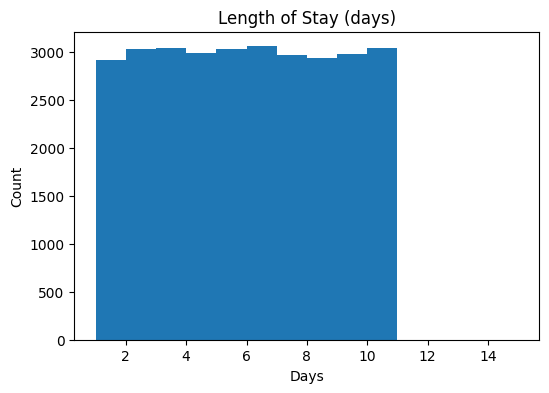

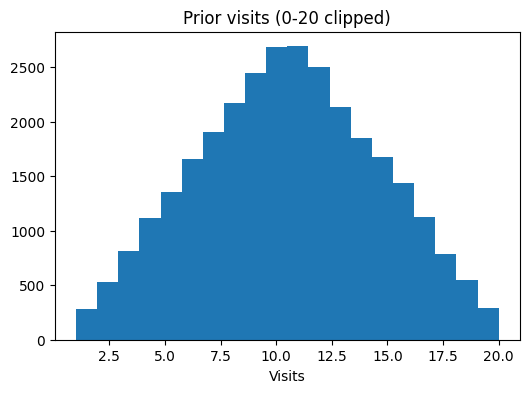

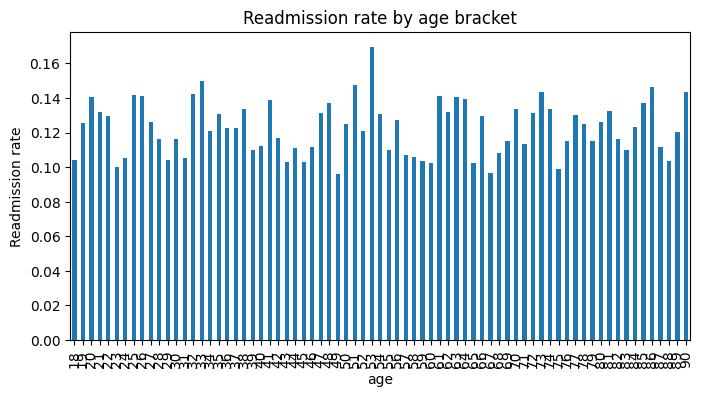

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Target balance
print("Readmitted distribution (binary):")
print(df['readmitted_binary'].value_counts(normalize=True))

# Distribution of time_in_hospital
plt.figure(figsize=(6,4))
plt.hist(df['length_of_stay'].dropna(), bins=range(1,16))
plt.title("Length of Stay (days)")
plt.xlabel("Days")
plt.ylabel("Count")
plt.show()

# Prior visits histogram
plt.figure(figsize=(6,4))
plt.hist(df['prior_visits'].clip(0,20), bins=20)
plt.title("Prior visits (0-20 clipped)")
plt.xlabel("Visits")
plt.show()

# Age categories vs readmission rate
plt.figure(figsize=(8,4))
age_rates = df.groupby('age')['readmitted_binary'].mean().sort_index()
age_rates.plot(kind='bar')
plt.ylabel("Readmission rate")
plt.title("Readmission rate by age bracket")
plt.show()

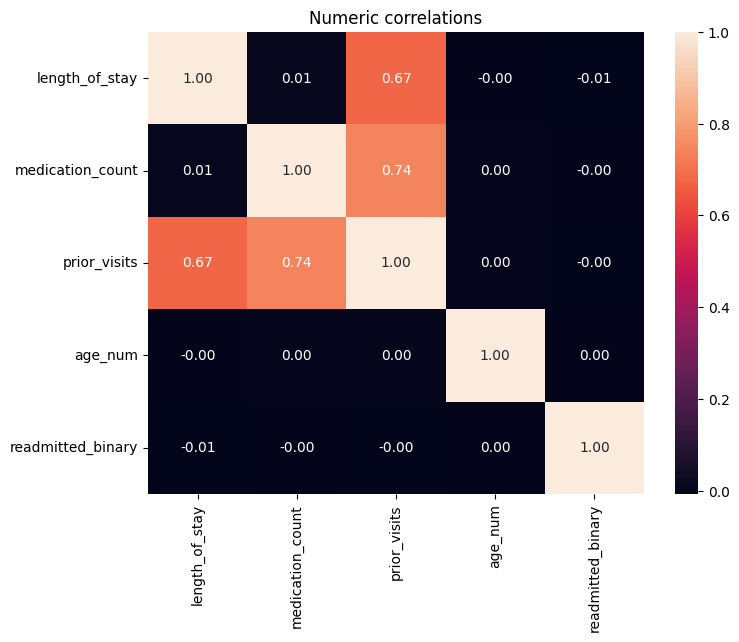

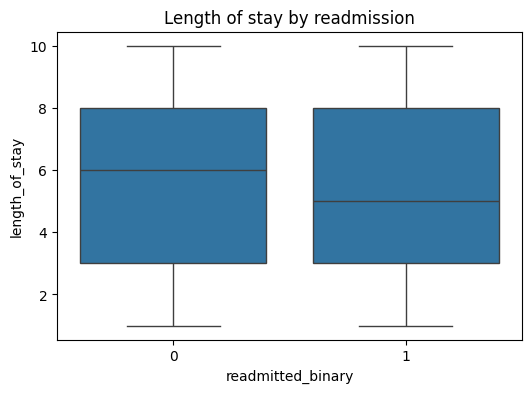

In [52]:
plt.figure(figsize=(8,6))
num_for_corr = ['length_of_stay','medication_count','prior_visits','age_num','readmitted_binary']
sns.heatmap(df[num_for_corr].corr(), annot=True, fmt=".2f")
plt.title("Numeric correlations")
plt.show()

# Boxplot: time_in_hospital by readmission
plt.figure(figsize=(6,4))
sns.boxplot(x='readmitted_binary', y='length_of_stay', data=df)
plt.title("Length of stay by readmission")
plt.show()

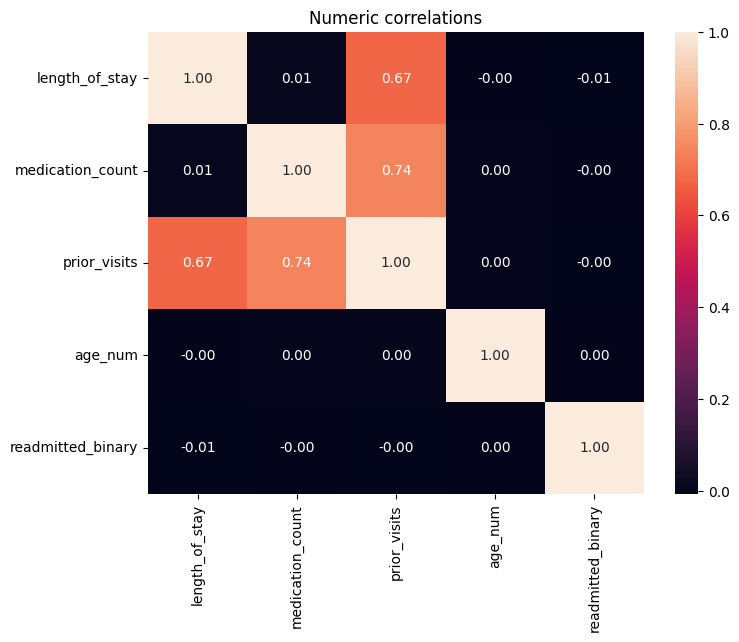

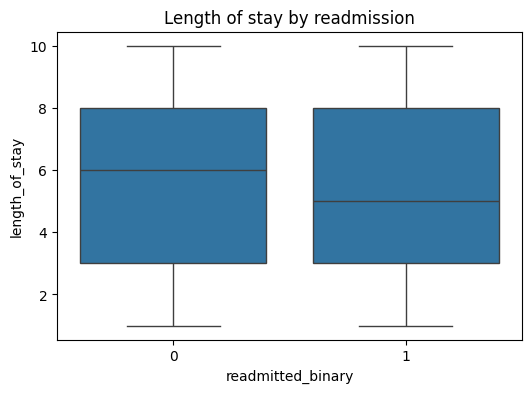

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
num_for_corr = ['length_of_stay','medication_count','prior_visits','age_num','readmitted_binary']
sns.heatmap(df[num_for_corr].corr(), annot=True, fmt=".2f")
plt.title("Numeric correlations")
plt.show()

# Boxplot: time_in_hospital by readmission
plt.figure(figsize=(6,4))
sns.boxplot(x='readmitted_binary', y='length_of_stay', data=df)
plt.title("Length of stay by readmission")
plt.show()

In [54]:
# Filter examples - adjust values to explore
filtered = df[
    (df['age'] >= 70) &          # age is 70 or greater (change as needed)
    (df['length_of_stay'] >= 3)
]
print("Filtered rows:", filtered.shape[0])
display(filtered.head(5))

Filtered rows: 6828


,patient_id,age,gender,blood_pressure,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,readmitted_30_days,readmitted_binary,age_num,prior_visits,high_glucose,high_a1c
3,4,84,Female,123/80,153,31.5,No,Yes,3,10,Home,No,0,84,13,0,0
5,6,75,Female,139/100,194,33.5,No,Yes,0,10,Home,No,0,75,10,0,0
14,15,87,Other,110/93,277,38.7,Yes,No,6,3,Home,Yes,1,87,9,0,0
15,16,90,Other,127/93,230,20.0,No,Yes,0,3,Home,No,0,90,3,0,0
17,18,80,Female,116/89,217,37.0,No,Yes,8,3,Home,No,0,80,11,0,0


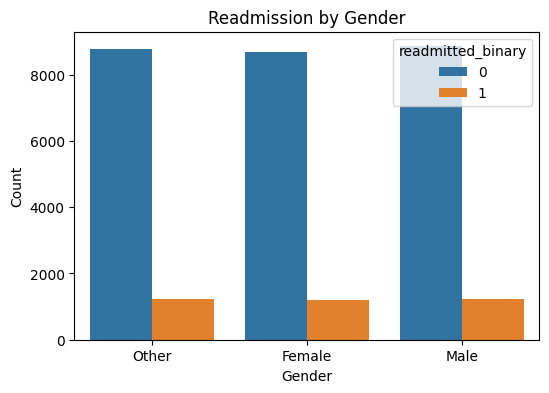

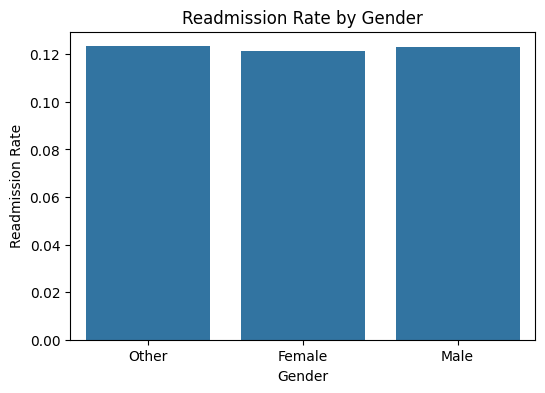

In [55]:
# Explore Gender distribution and readmission rate
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', hue='readmitted_binary', data=df)
plt.title('Readmission by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(x='gender', y='readmitted_binary', data=df, errorbar=None)
plt.title('Readmission Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Readmission Rate')
plt.show()

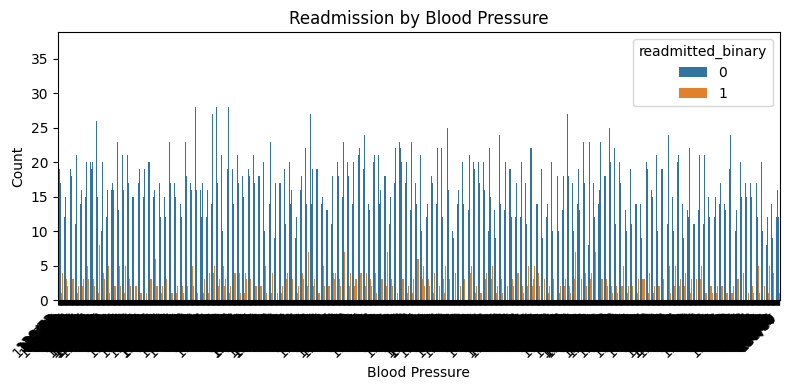

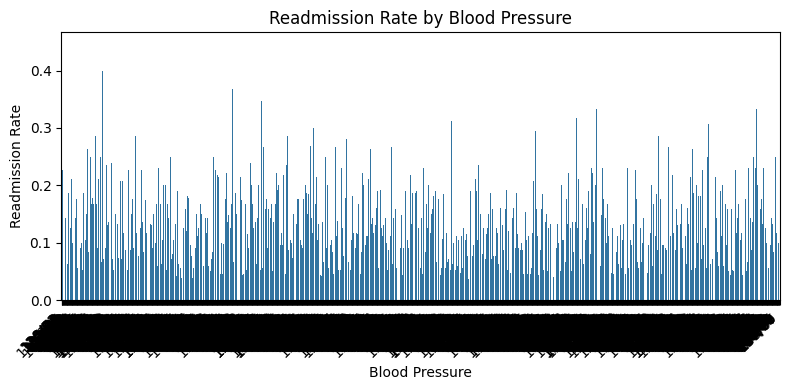

In [56]:
# Explore Blood Pressure distribution and readmission rate
plt.figure(figsize=(8, 4))
sns.countplot(x='blood_pressure', hue='readmitted_binary', data=df)
plt.title('Readmission by Blood Pressure')
plt.xlabel('Blood Pressure')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x='blood_pressure', y='readmitted_binary', data=df, errorbar=None)
plt.title('Readmission Rate by Blood Pressure')
plt.xlabel('Blood Pressure')
plt.ylabel('Readmission Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

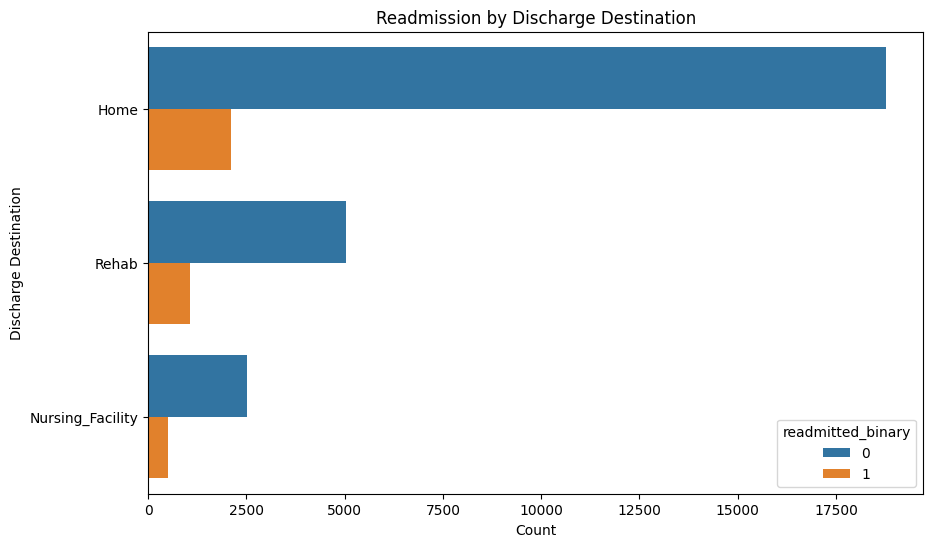

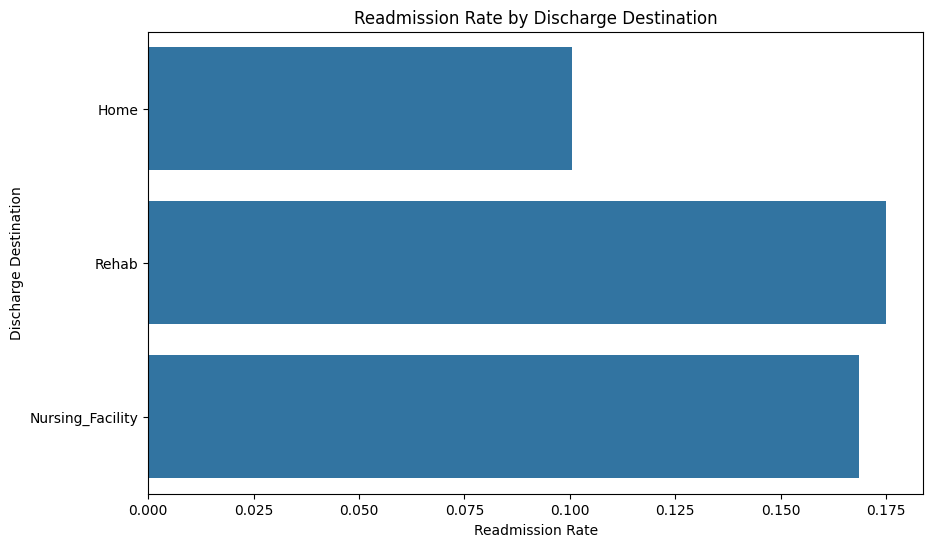

In [57]:
# Explore Discharge Destination distribution and readmission rate
plt.figure(figsize=(10, 6))
sns.countplot(y='discharge_destination', hue='readmitted_binary', data=df, order=df['discharge_destination'].value_counts().index)
plt.title('Readmission by Discharge Destination')
plt.xlabel('Count')
plt.ylabel('Discharge Destination')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(y='discharge_destination', x='readmitted_binary', data=df, errorbar=None, order=df['discharge_destination'].value_counts().index)
plt.title('Readmission Rate by Discharge Destination')
plt.xlabel('Readmission Rate')
plt.ylabel('Discharge Destination')
plt.show()

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Select a manageable set of features
features = [
    'age_num','length_of_stay','medication_count',
    'prior_visits','high_glucose','high_a1c','gender','blood_pressure','discharge_destination'
]
# Ensure all exist
features = [f for f in features if f in df.columns]

X = df[features].copy()
y = df['readmitted_binary'].astype(int)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessing: numeric scaler + one-hot for selected categoricals
numeric_features = ['age_num','length_of_stay','medication_count','prior_visits','high_glucose','high_a1c']
categorical_features = ['gender','blood_pressure','discharge_destination']
categorical_features = [c for c in categorical_features if c in X_train.columns]

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.88      1.00      0.93      5265
           1       0.00      0.00      0.00       735

    accuracy                           0.88      6000
   macro avg       0.44      0.50      0.47      6000
weighted avg       0.77      0.88      0.82      6000

ROC AUC: 0.5319092195282671


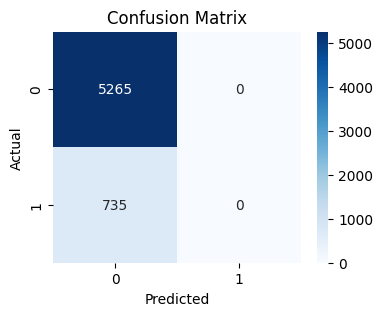

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

clf = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [60]:
# Extract feature names after one-hot
ohe = clf.named_steps['pre'].named_transformers_['cat']
ohe_feature_names = []
if hasattr(ohe, 'get_feature_names_out'):
    ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
else:
    # older versions fallback
    ohe_feature_names = []

num_names = numeric_features
all_feature_names = num_names + ohe_feature_names

coefs = clf.named_steps['clf'].coef_[0]
coef_df = pd.DataFrame({
    "feature": all_feature_names,
    "coef": coefs
}).sort_values(by='coef', key=lambda x: x.abs(), ascending=False)

coef_df.head(20)

,feature,coef
302,blood_pressure_119/83,1.530729
865,blood_pressure_137/88,1.512998
1184,blood_pressure_147/97,1.509083
400,blood_pressure_122/88,1.468676
810,blood_pressure_135/95,1.422942
1253,blood_pressure_150/73,1.346996
566,blood_pressure_127/99,1.331341
1436,blood_pressure_156/70,1.264875
598,blood_pressure_129/100,1.257930
770,blood_pressure_134/86,1.228419
